In [17]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [134]:
 class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0 # grad 0 means changing this variable will not affect the loss fn
    # _backward fn is used to calculate the gradients of the variable with respect to result
    # this should be set in the fns where we are returning a Value result from inputs
    self._backward = lambda: None # for leaf nodes this can be set to None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, _children=(self, other), _op='+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __radd__(self, other): # other + self
    return self + other

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, _children=(self, other), _op='*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other): # other * self
    return self * other


  def __truediv__(self, other): # self / other
    return self * other**-1 # a more general case for division

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __rsub__(self, other): # other - self
    return self + (-other)

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    def _backward():
      # d(tanh(x))/dx = 1 - tanh(x)**2
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out


  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int and float as of now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += (other * self.data ** (other - 1)) * out.grad
    out._backward = _backward
    return out


  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    # dx/dx = 1.0
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
e = a * b; e.label = 'e'
c = Value(10.0, label = 'c')
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [91]:
a = Value(2, label='a')
2 * a

Value(data=4)

In [13]:
from graphviz import Digraph

def trace(root):
  # builds set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')

    if n._op:
      # if this value is a result of some operation create a operation node for it
      dot.node(name=uid + n._op, label=n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

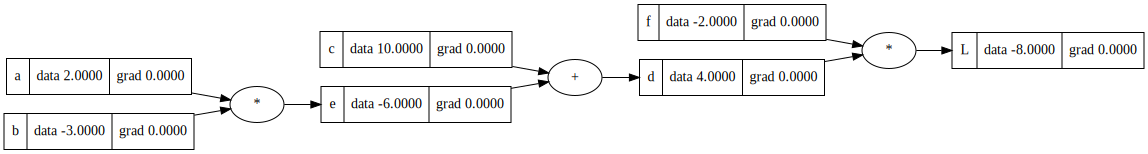

In [15]:
draw_dot(L)

- find dL/dL, which is 1
- find dL/dd, which is -2, because L = f * d
- find dL/df, whcih is 4, because L = f * d
- find dL/dc, which is dL/dd * dd/dc, which is -2 * 1, because d = c + e
- find dL/de, which is dL/dd * dd/de, which is -2 * 1, because d = c + e
- find dL/da, which is dL/de * de/da, which is -2 * -3, because e = a * b
- find dL/db, which is dL/de * de/db, which is -2 * 2, because e = a * b

In [93]:
# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# -----tanh------
e = (2 * n).exp(); e.label = 'e'
o = (e - 1) / (e + 1); o.label = 'o'
# ---------------
o.backward()

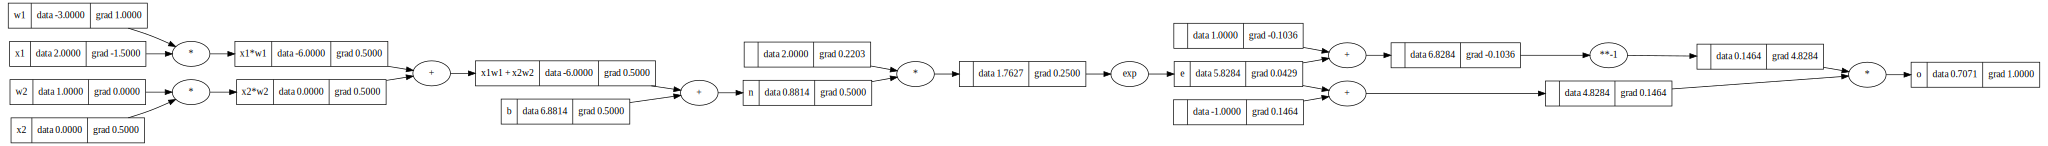

In [94]:
draw_dot(o)

In [129]:
import random

class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    # w * x + b
    act = sum([w * x for w, x in zip(self.w, x)], self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]


class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    # return the last layer which would be the output layer
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [250]:
1

[Value(data=0.2133796939832304),
 Value(data=0.7820602513539208),
 Value(data=0.29268115031500586),
 Value(data=0.7374090022004072)]

In [251]:
# Train the network for more iterations
for k in range(1000):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum([(ygt - yout)**2 for ygt, yout in zip(ys, ypred)])

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.01 * p.grad  # smaller learning rate

  if k % 100 == 0:  # print every 100 iterations
    print(k, loss.data)


0 1.1371006194901967
100 0.949178118357269
200 0.912166880503952
300 0.8784043052952277
400 0.8403808770860152
500 0.7924577833063907
600 0.7244873251802306
700 0.6177798569897371
800 0.4616639726654399
900 0.3038266806861749


In [252]:
ypred

[Value(data=0.08460999207403053),
 Value(data=0.7648991395956201),
 Value(data=0.6736244348348751),
 Value(data=0.1556687388313784)]